## ***Outliers Detection using `Isolation Forest`***

---
#### **Notebook Contents**
1. [Libraries import](#Package_import)
2. [Datasets import](#Dataset_import)
3. [Understanding Isolation Forest](#Understanding_Isolation_Forest)
    1. [How it splits the data?](#How_Isolation_Forest_Works?)
    2. [Anomaly Score Formula](#IF_Anomaly_Score_Formula)
    3. [Problems in Isolation Forest](#Problems_in_Isolation_Forest)
        1. [Why it has these problems?](#Why_Isolation_Forest_does_that?)
3. [EIF](#EIF)
    1. [Difference b/w IF & EIF](#Difference_bw_IF_and_EIF)
4. [IF Sklearn Implementation](#IF_Sklearn_Implementation)
    1. [Base Estimator](#Base_Estimator)
    2. [Base Estimators randomly sampled features](#Base_Estimator_Randomly_Sampled_Features)
    3. [Understanding `Decision Function` & `Score Samples`](#Understanding_Decision_Function_Score_Samples)
    4. [Results Analysis](#Results_Analysis)
    5. [Conclusion](#Conclusion)

#### **Package_import**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
import statsmodels as stm

from sklearn.datasets import load_breast_cancer, load_iris
from sklearn.neighbors import LocalOutlierFactor
from sklearn.ensemble import IsolationForest

%matplotlib inline

In [2]:
pd.set_option('display.max_rows',151)

#### **Dataset_import**

In [3]:
cancer_dataset, iris_dataset = load_breast_cancer(), load_iris()

##### **1. Cancer Dataset**
##### **Segregating Features and Labels**

In [4]:
X_cancer_df = pd.DataFrame(cancer_dataset.data, columns=cancer_dataset.feature_names)
y_cancer_df = pd.DataFrame(cancer_dataset.target, columns=['Label'])

In [5]:
X_cancer_df.shape

(569, 30)

In [6]:
cancer_dataset.target_names

array(['malignant', 'benign'], dtype='<U9')

In [7]:
y_cancer_df.shape, y_cancer_df.value_counts()

((569, 1),
 Label
 1        357
 0        212
 dtype: int64)

##### **2. Iris Dataset**
##### **Segregating Features and Labels**

In [8]:
X_iris_df = pd.DataFrame(iris_dataset.data,columns=iris_dataset.feature_names)
y_iris_df = pd.DataFrame(iris_dataset.target,columns=['Label'])

In [9]:
X_iris_df.shape, X_iris_df.head()

((150, 4),
    sepal length (cm)  sepal width (cm)  petal length (cm)  petal width (cm)
 0                5.1               3.5                1.4               0.2
 1                4.9               3.0                1.4               0.2
 2                4.7               3.2                1.3               0.2
 3                4.6               3.1                1.5               0.2
 4                5.0               3.6                1.4               0.2)

In [10]:
iris_dataset.target.shape, iris_dataset.target_names

((150,), array(['setosa', 'versicolor', 'virginica'], dtype='<U10'))

In [11]:
y_iris_df.shape, y_iris_df.value_counts()

((150, 1),
 Label
 2        50
 1        50
 0        50
 dtype: int64)

## **Understanding_Isolation_Forest**

In [12]:
from IPython.display import Image
from IPython.core.display import HTML

# Setting Images Path 
# Images Source :: Extended Isolation Forest Github :: https://github.com/sahandha/eif 
PATH = "E:\STUDY\PROJECTS\AAIC_Practice\MODULES\Module_3\Mod_3_Outliers_Detection\Isolation_Forest_Notes\\"

### ***`How_Isolation_Forest_Works?`***
**1. It is an unsupervised machine learning algorithm which is fundamentally based on the decision trees and build the ensemble forest.**

**2. The base estimator in Isolation Forest is Randomized Tree that subsamples the dataset in both row and feature wise.**

**3. It selects one feature randomly at a time to make a split or cut the branches and uses the random threshold value that exists b/w the range of min(feature value) & max(feature value).**

**4. The concept of impurity reduction totally followed here just like the normal decision trees with the intent to eliminate the outliers or anomaly very early in the split.**

**5. The assumption that it takes is that outliers or anomalies are the points which are away from the normal data points and usually isolated easily thus in very few initial splits we can find the outliers with the randomized approach at row, column and threshold level.**

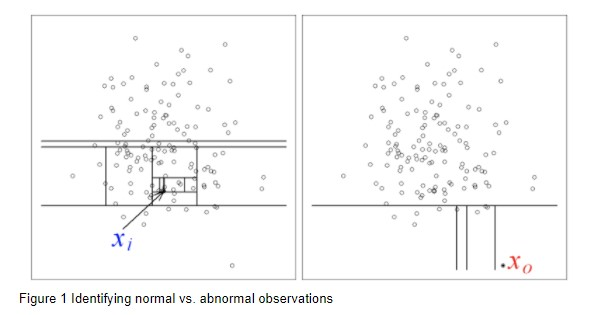

In [13]:
Image(filename = PATH + "1_IF_Random_Splits.jpg", width=700, height=700)

#### **As shown in the above figure:**
- **In the left image many splits are required to segregate the normal data point or,**
- **In other words we can say that we need traverse till the end of tree depth to find this element or,**
- **We can say that this Xi was common in so many nodes(from root to last decision node).**
- **On the other hand, in the right image the point Xo is an outlier which was segregated with only initial 3 splits.**

### **`The concept of Isolation Forest is that if we are going deep into the tree to find an element then such an element has very less chance of being an Outlier, because its shortest distance or path in the tree is large thus difficult to segregate from other points. Hence, it be declared as Inlier.`**

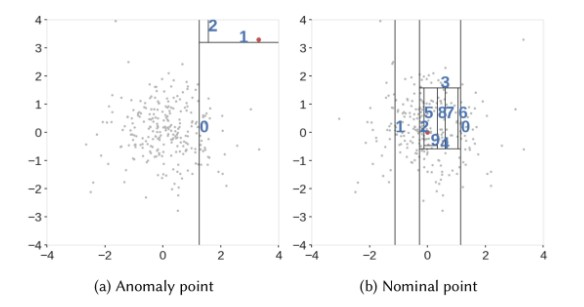

In [14]:
Image(filename = PATH + "2_IF_Random_Partition_Algo.jpg", width=800, height=800)

#### **Similar things are shown in the above figure where in the left with only 3 splits outlier been found(marked as red). Whereas, in the right red point is in the center of the density of points thus requiring 10 splits which means the anamoly score will be less thus no clear signs of distinct anamolies.**

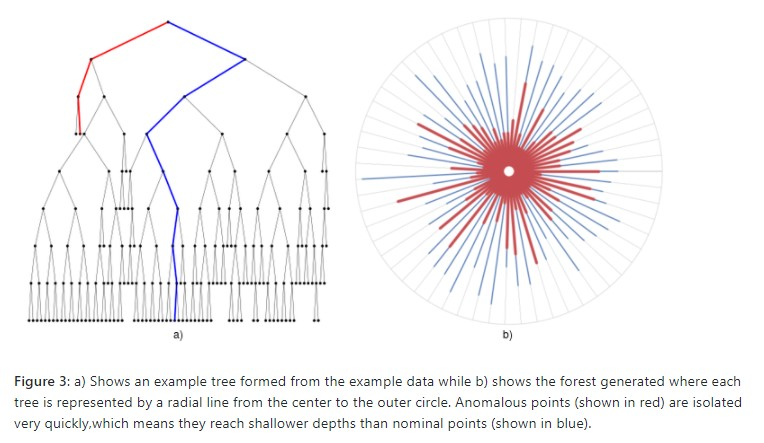

In [15]:
Image(filename = PATH + "7_IF_Tree_Forest.jpg", width=800, height=800)

#### **The above image is very nice in depicting the classification of anamolies; the red color shows the shorter depth of isolated outliers whereas the blue color shows the depth of normal point.**

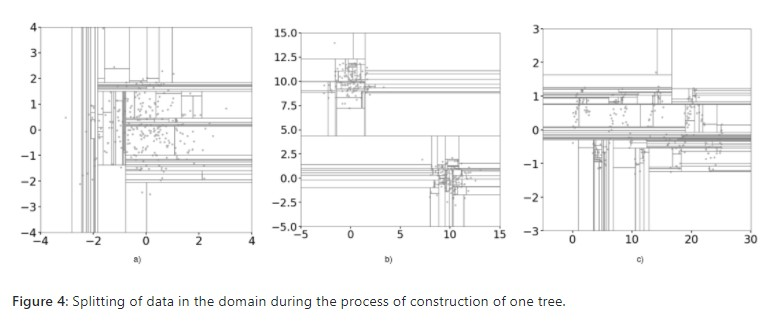

In [16]:
Image(filename = PATH + "8_IF_Splitting_of_Data_while_constructing_one_tree.jpg", width=950, height=950)

#### **In the above image this is how the Isolation Forest splits or divides the data; as it forms the axis parallel lines for creating the branches in the trees; data values smaller than randomly selected threshold value goes into branch and others into right branch.**

### ***`This random splitting which is the power of Isolation Forest is also the main of bias because of these axis parallel lines regions where threse are no points shows the artifical less anomaly scores which is not correct. (Explained in problems)`***

### ***`IF_Anomaly_Score_Formula`***

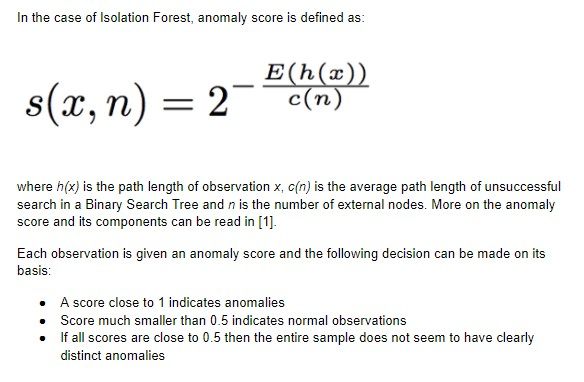

In [17]:
Image(filename = PATH + "3_IF_Anamoly_Score_Formula.jpg", width=700, height=700)

## ***`The anomaly score is created on the basis of all trees in the forest and the depth the point reaches in these trees.`***

### ***`Problems_in_Isolation_Forest`***

#### **Here, we will talk about the problems or disadvantages or biasness of Isolation forest.**

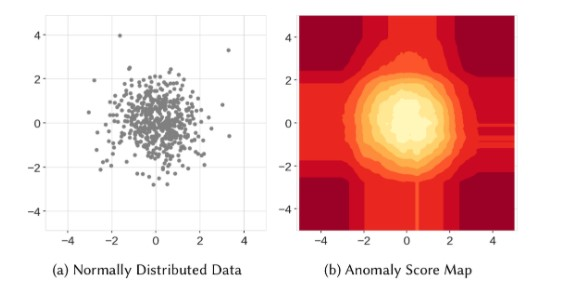

In [18]:
Image(filename = PATH + "4_IF_Scoremap_Gauss_Data.jpg", width=700, height=700)

#### **The above left image is the gaussian distributed data, now as per the understanding of normal distributions there shouldn't be any outliers and the anomaly score should increase as we move away from the center in the right image.**

### ***`Now, Isolation Forest (right side image) is correctly showing the center [0,0] with light color region that means very low anomaly score and it is gradually increasing the strength of the color as we move away from the center [0,0]. For example, compare the color at [0,0] and [-2,0], the later has a dark shade of red as compared to the center.`***

### ***`But, Isolation Forest doesn't stops here, as it also created the un-wanted axis parallel lines surrounding the circle other than the 4 corners of the image which are totally(dark red corners) with higher anomaly score. These axes parallel lines should not be their logically but Isolation Forest creates them artifically which affects the overall ANOMALY SCORE. Becuase, ideally, the entire image should only have the middle circle which means points outside the circle will be with high anomaly score.`***

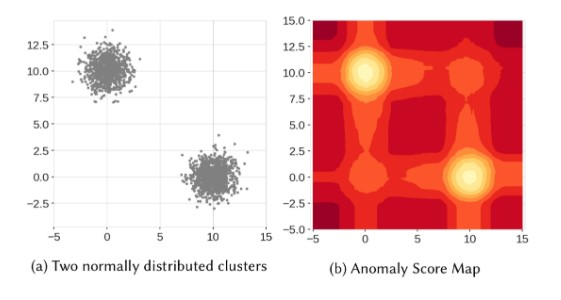

In [19]:
Image(filename = PATH + "6_IF_Scoremap_Two_Gauss_Clusters.jpg", width=700, height=700)

#### **In the above image on the left side we have two normally distributed clusters of data and on the right we have the anomaly score map.**

### ***`Now, if we closely examine the right side image then should only have 2 circles at [0,10] and [10,0]. Other than these two circles, Isolation Forest also created 2 artifical circles at [0,0] and [10,10] which were not present in the actual data. In addition to these 2 artificial circles it also created the axes parallel lines surrounding all the 4 lines. So, all of these were totally not present in the actual data and it shouldn't have been created by IF.`***

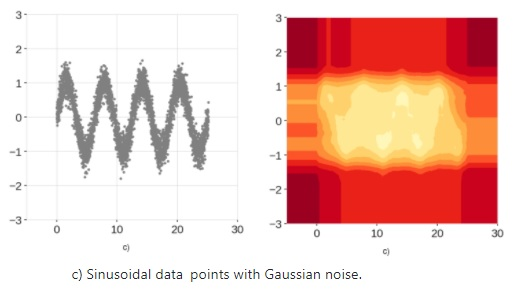

In [20]:
Image(filename = PATH + "5_IF_Scoremap_Sinusoidal_Data.jpg", width=700, height=700)

#### **In the above image on the left side we have sinusoidal data and on the right we have the anomaly score map.**

### ***`Because Isolation Forest can only have the axes parallel lines thus we lose the shape of the data(no wave in the anomaly scores), this is again not the right thing. Along with this the lines are also surrounding the central region that is again unwanted.`***

### ***`Why_Isolation_Forest_does_that?`***

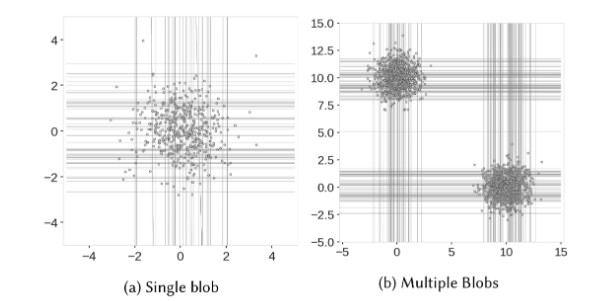

In [21]:
Image(filename = PATH + "11_IF_Problems.jpg", width=850, height=850)

### ***`Point to note here is that the area in the images where the density of points is high also has higher number of axis paralled lines splitting the branches. And, if we closely observe the images then we can also found that area where there are actually no points originally also been included unwantedly only due to the nature of lines.`*** 

### ***`For example, in image (b) look at the point [0,0] and [10,10] so many lines are passing across these regions, but as the lines can only be parallel to the axes, these are regions that contain many branch cuts and only a few/single or no observations exists, which results in improper anomaly scores calculation for some of the observations.`***

# ***`EIF`***
### ***The solution to above problems of Isolation Forest is the `Extended Isolation Forest` or also known as `Isolation Forest Extension`.***

### ***Difference_bw_IF_and_EIF***

#### ***`The only difference b/w IF and EIF is that the latter allows the slicing of data using hyperplanes with random slopes which results in improved score maps. Instead of selecting a random feature and then random value within the range of data, it selects:`***
- **the random slope for the branch cut**
- **random intercept chosen from the range of available values from the training data**

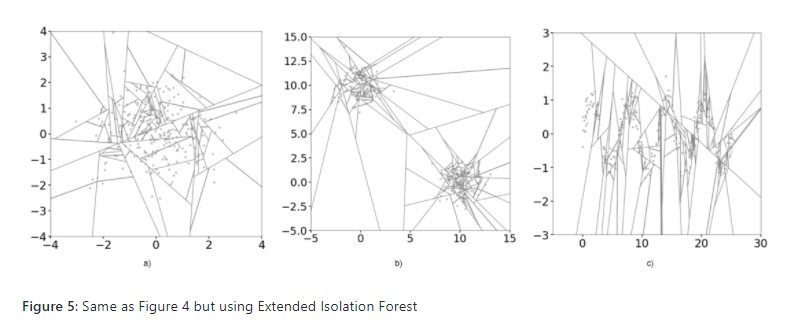

In [22]:
Image(filename = PATH + "9_EIF_Hyperplanes_splitting_the_space.jpg", width=850, height=850)

#### **The inclusion of random hyperplanes no more creating the unwanted axis parallel line cuts where the density of points is high.**

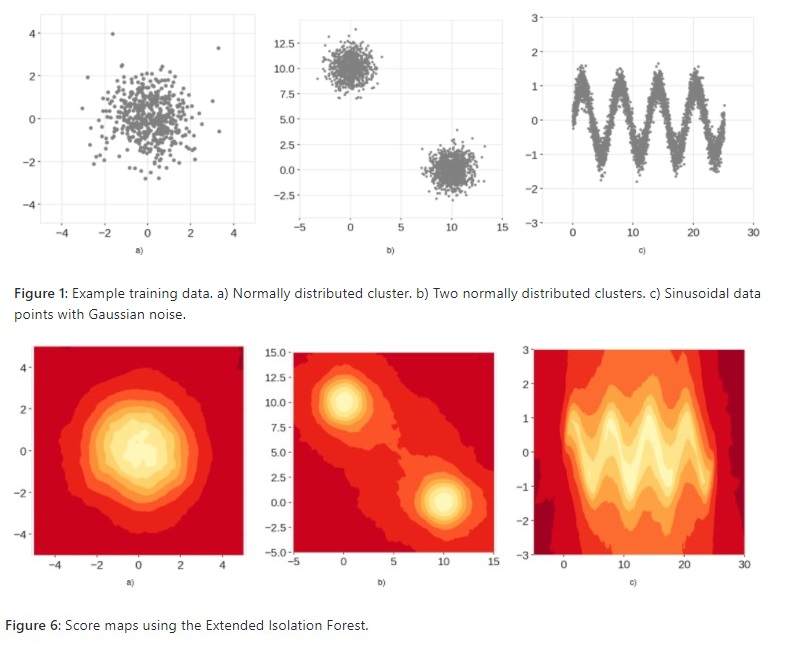

In [23]:
Image(filename = PATH + "10_EIF_Score_Maps.jpg", width=850, height=850)

#### **As shown in the above images EIF gives us better anomaly score maps also it doesn't lose the shape of the original data. In the (b) image the region where the two circles are linking with each other is the point where the anomaly is score is high because that point or area is far away from both the circles.**

### **IF_Sklearn_Implementation**

In [24]:
iso_for = IsolationForest(n_estimators=15,
                              max_samples=25,
                              contamination=0.05,
                              max_features=2,
                              bootstrap=False,
                              random_state=41,
                              verbose=1,
                              n_jobs=-1)

In [25]:
iso_for.fit(X_iris_df)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.1s finished


IsolationForest(contamination=0.05, max_features=2, max_samples=25,
                n_estimators=15, n_jobs=-1, random_state=41, verbose=1)

In [26]:
X_iris_df.shape

(150, 4)

In [27]:
np.ceil(np.log2(25))

5.0

#### **Base_Estimator**
##### **Using ExtraTreeRegressor as the base estimator**

In [28]:
iso_for.estimators_

[ExtraTreeRegressor(max_depth=5, max_features=1, random_state=716905170),
 ExtraTreeRegressor(max_depth=5, max_features=1, random_state=180789943),
 ExtraTreeRegressor(max_depth=5, max_features=1, random_state=1315178973),
 ExtraTreeRegressor(max_depth=5, max_features=1, random_state=1681872075),
 ExtraTreeRegressor(max_depth=5, max_features=1, random_state=280069627),
 ExtraTreeRegressor(max_depth=5, max_features=1, random_state=1055549073),
 ExtraTreeRegressor(max_depth=5, max_features=1, random_state=1764538871),
 ExtraTreeRegressor(max_depth=5, max_features=1, random_state=405848271),
 ExtraTreeRegressor(max_depth=5, max_features=1, random_state=1224622560),
 ExtraTreeRegressor(max_depth=5, max_features=1, random_state=2088199739),
 ExtraTreeRegressor(max_depth=5, max_features=1, random_state=1220789893),
 ExtraTreeRegressor(max_depth=5, max_features=1, random_state=271136312),
 ExtraTreeRegressor(max_depth=5, max_features=1, random_state=1321442735),
 ExtraTreeRegressor(max_depth=

#### **Base_Estimator_Randomly_Sampled_Features**
##### **Features randomly selected for every extra tree regressors or base estimators**

In [29]:
iso_for.estimators_features_

[array([1, 0]),
 array([0, 1]),
 array([0, 3]),
 array([1, 0]),
 array([2, 0]),
 array([2, 3]),
 array([1, 2]),
 array([2, 1]),
 array([2, 3]),
 array([0, 2]),
 array([3, 2]),
 array([2, 3]),
 array([0, 2]),
 array([2, 3]),
 array([3, 0])]

#### **Base_Estimator_Randomly_Sampled_Observations**
##### **Observations randomly selected for training the extra tree regressors or base estimators**

In [30]:
iso_for.estimators_samples_

[array([125,  87,  73,  25,  96, 103,  43,  15,  70,  44, 109,  57, 111,
         55,  16, 144, 137,   2,  24,  38, 128,   9,  32,  31, 126]),
 array([ 78,  62,  99,  86,  96,  33,  17, 117,  61, 126,  27,  88, 127,
         94, 121,  49,  16,  77,  58,  46,  57, 149,  87, 123,  72]),
 array([ 71,  54,  13,   5,  62,  29,  34, 121,  47,  61,  17,  12, 124,
         84, 114, 123,  95,   1,  83, 133, 105,  58,  52, 146,  96]),
 array([ 32,  86, 118, 121,  47,   0, 103,  60,  57,   9,  16, 130, 148,
         45,  63,  76,  41,  93,  58,  12,  71,  96,  52,  10,  46]),
 array([ 98,  15, 135, 123,  29, 145,  92,  66, 109, 142, 149,   2,  63,
        120, 111,  84, 136,  22, 101,  45,  33, 134, 108, 126,  24]),
 array([120,  20, 100,  64, 138,  17, 141, 140,  71,  37,  11,   1,  72,
         56,  23,  57,  70,  45,  21, 110, 122,  28, 108,  66, 139]),
 array([ 10,  65, 105, 108,  57,  68,  33,  25,  30, 114,  80,   0, 141,
         21, 129, 146,  66,  89,  56,  70,  67,   6,  15,  99,   3]),

In [31]:
iso_for.estimators_samples_[0].shape

(25,)

In [32]:
iso_for.offset_

-0.5714171057941879

#### **Understanding_Decision_Function_Score_Samples**

In [33]:
X_iris_df['Avg_Anomaly_Scr'] = iso_for.decision_function(X_iris_df)

In [34]:
X_iris_df['Opp_Anomaly_Scr'] = iso_for.score_samples(X_iris_df.iloc[:,0:4])

## ***`Decision_Function` gives the average anomaly score of an observation based on its score from every tree. If it is less than 0 then it means or indicates the abnormality.***

## ***`Score_Samples` gives the opposite of average anomaly score of an observation based on its score from every tree. If it is less than offset then it means or indicates the abnormality.***

In [35]:
X_iris_df['Pred'] = iso_for.predict(X_iris_df.iloc[:,0:4])

In [36]:
X_iris_df[np.sign(X_iris_df['Pred']) != 1]

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),Avg_Anomaly_Scr,Opp_Anomaly_Scr,Pred
13,4.3,3.0,1.1,0.1,-0.024954,-0.596371,-1
15,5.7,4.4,1.5,0.4,-0.018381,-0.589798,-1
41,4.5,2.3,1.3,0.3,-0.030936,-0.602353,-1
93,5.0,2.3,3.3,1.0,-0.000144,-0.571561,-1
98,5.1,2.5,3.0,1.1,-0.008264,-0.579681,-1
117,7.7,3.8,6.7,2.2,-0.048490,-0.619907,-1
118,7.7,2.6,6.9,2.3,-0.112292,-0.683709,-1
122,7.7,2.8,6.7,2.0,-0.040678,-0.612095,-1


#### **``decision_function = score_samples - offset_``**
- **``offset_`` is defined as follows:**
    - **When the contamination parameter is set to "auto", the offset is equal to -0.5 as the scores of inliers are close to 0 and the scores of outliers are close to -1.**
    - **When a contamination parameter different than "auto" is provided, the offset is defined in such a way we obtain the expected number of outliers (samples with decision function < 0) in training.**

In [37]:
X_iris_df[np.sign(X_iris_df['Avg_Anomaly_Scr']) != 1]

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),Avg_Anomaly_Scr,Opp_Anomaly_Scr,Pred
13,4.3,3.0,1.1,0.1,-0.024954,-0.596371,-1
15,5.7,4.4,1.5,0.4,-0.018381,-0.589798,-1
41,4.5,2.3,1.3,0.3,-0.030936,-0.602353,-1
93,5.0,2.3,3.3,1.0,-0.000144,-0.571561,-1
98,5.1,2.5,3.0,1.1,-0.008264,-0.579681,-1
117,7.7,3.8,6.7,2.2,-0.048490,-0.619907,-1
118,7.7,2.6,6.9,2.3,-0.112292,-0.683709,-1
122,7.7,2.8,6.7,2.0,-0.040678,-0.612095,-1


#### **If we compare the above results of IF with LOF then some of these are marked as Outliers from both the techniques.**

In [38]:
-1 * np.unique(X_iris_df['Avg_Anomaly_Scr'] - X_iris_df['Opp_Anomaly_Scr'])

array([-0.57141711])

#### **Calculated the Offset value manually**

In [39]:
X_iris_df[X_iris_df['Avg_Anomaly_Scr'] < 0]

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),Avg_Anomaly_Scr,Opp_Anomaly_Scr,Pred
13,4.3,3.0,1.1,0.1,-0.024954,-0.596371,-1
15,5.7,4.4,1.5,0.4,-0.018381,-0.589798,-1
41,4.5,2.3,1.3,0.3,-0.030936,-0.602353,-1
93,5.0,2.3,3.3,1.0,-0.000144,-0.571561,-1
98,5.1,2.5,3.0,1.1,-0.008264,-0.579681,-1
117,7.7,3.8,6.7,2.2,-0.048490,-0.619907,-1
118,7.7,2.6,6.9,2.3,-0.112292,-0.683709,-1
122,7.7,2.8,6.7,2.0,-0.040678,-0.612095,-1


#### **Outliers are the points whose Anomaly score is less than 0 or -ve.**

In [40]:
X_iris_df[X_iris_df['Opp_Anomaly_Scr'] < iso_for.offset_]

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),Avg_Anomaly_Scr,Opp_Anomaly_Scr,Pred
13,4.3,3.0,1.1,0.1,-0.024954,-0.596371,-1
15,5.7,4.4,1.5,0.4,-0.018381,-0.589798,-1
41,4.5,2.3,1.3,0.3,-0.030936,-0.602353,-1
93,5.0,2.3,3.3,1.0,-0.000144,-0.571561,-1
98,5.1,2.5,3.0,1.1,-0.008264,-0.579681,-1
117,7.7,3.8,6.7,2.2,-0.048490,-0.619907,-1
118,7.7,2.6,6.9,2.3,-0.112292,-0.683709,-1
122,7.7,2.8,6.7,2.0,-0.040678,-0.612095,-1


#### **Outliers are the points whose Opposite Anomaly score is less than the offset value.**

### **Results_Analysis**
##### **Let's visualize some results**

In [41]:
if_results = pd.concat([X_iris_df.copy(deep=True),y_iris_df.copy(deep=True)],axis=1)
tag_dict = {1:'Inlier',-1:'Outlier'}
if_results['Pred_Tag'] = if_results['Pred'].apply(lambda val: tag_dict.get(val))
if_results.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),Avg_Anomaly_Scr,Opp_Anomaly_Scr,Pred,Label,Pred_Tag
0,5.1,3.5,1.4,0.2,0.097173,-0.474244,1,0,Inlier
1,4.9,3.0,1.4,0.2,0.093524,-0.477893,1,0,Inlier
2,4.7,3.2,1.3,0.2,0.076375,-0.495042,1,0,Inlier
3,4.6,3.1,1.5,0.2,0.083507,-0.487910,1,0,Inlier
4,5.0,3.6,1.4,0.2,0.097173,-0.474244,1,0,Inlier


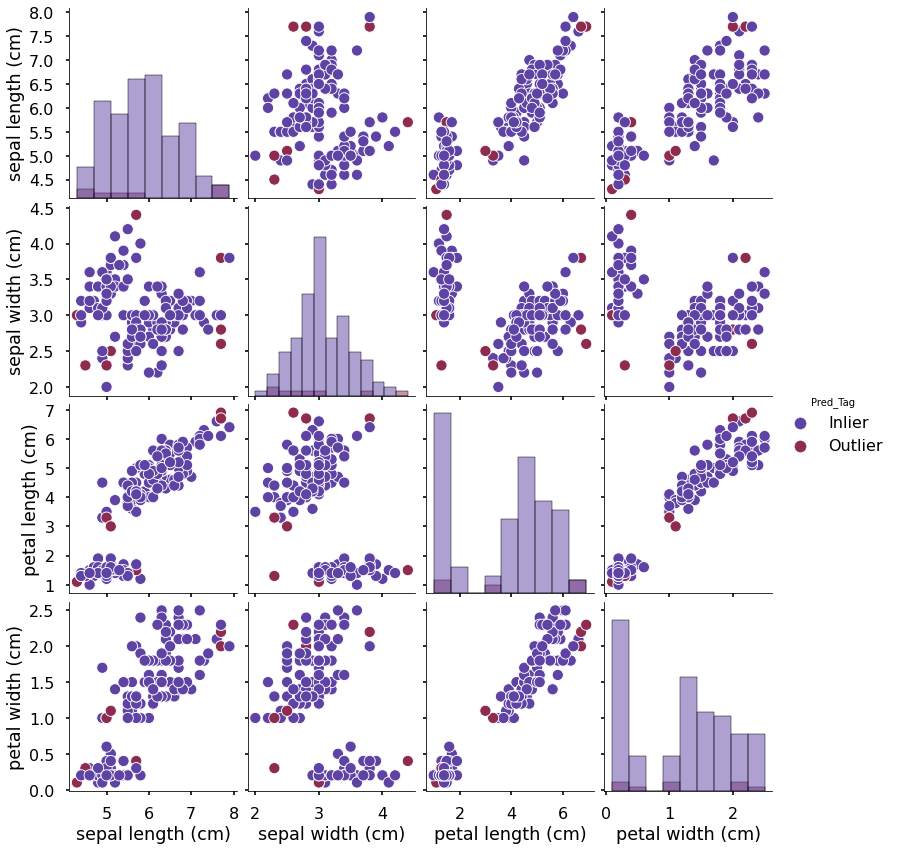

In [53]:
with plt.style.context('seaborn-poster'):
    g = sns.pairplot(data=if_results[['sepal length (cm)','sepal width (cm)','petal length (cm)','petal width (cm)','Pred_Tag']],
                 hue='Pred_Tag',palette='twilight',height=3,aspect=0.9,diag_kind='hist')

#### **The first look gave me an impression of slightly better results are compared to LOF.**

##### **Let's do some more plotting**

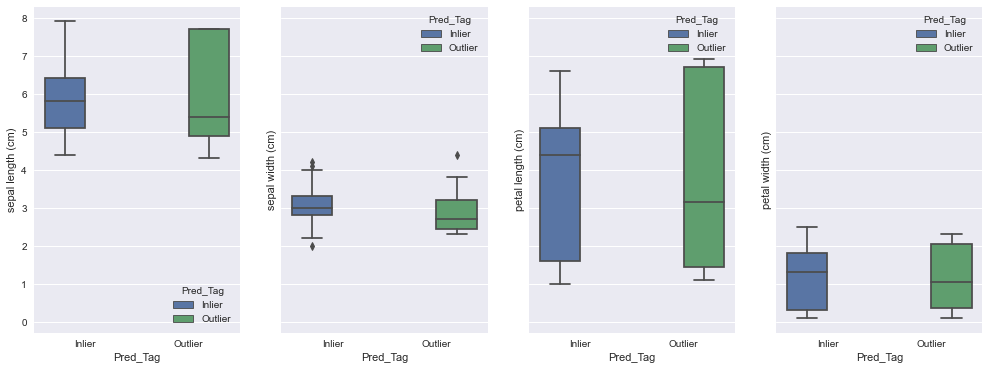

In [43]:
with plt.style.context('seaborn'):
    fig, ax = plt.subplots(1,4,sharex=True,sharey=True,squeeze=True,figsize=(17,6))
    sns.boxplot(data=if_results,x='Pred_Tag',y='sepal length (cm)',hue='Pred_Tag',ax=ax[0])
    sns.boxplot(data=if_results,x='Pred_Tag',y='sepal width (cm)',hue='Pred_Tag',ax=ax[1])
    sns.boxplot(data=if_results,x='Pred_Tag',y='petal length (cm)',hue='Pred_Tag',ax=ax[2])
    sns.boxplot(data=if_results,x='Pred_Tag',y='petal width (cm)',hue='Pred_Tag',ax=ax[3])
    plt.show()

In [44]:
if_results.groupby(['Pred_Tag'])[['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)','petal width (cm)']].min()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
Pred_Tag,,,,
Inlier,4.4,2.0,1.0,0.1
Outlier,4.3,2.3,1.1,0.1


In [45]:
if_results.groupby(['Pred_Tag'])[['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)','petal width (cm)']].median()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
Pred_Tag,,,,
Inlier,5.8,3.0,4.40,1.30
Outlier,5.4,2.7,3.15,1.05


In [46]:
if_results.groupby(['Pred_Tag'])[['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)','petal width (cm)']].max()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
Pred_Tag,,,,
Inlier,7.9,4.2,6.6,2.5
Outlier,7.7,4.4,6.9,2.3


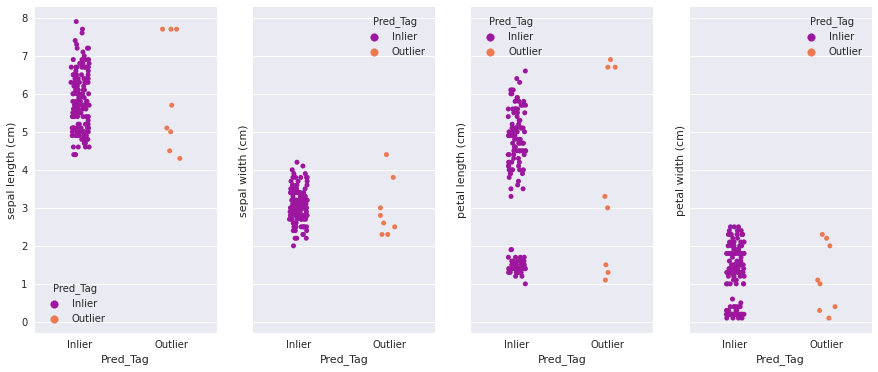

In [47]:
with plt.style.context('seaborn'):
    fig, ax = plt.subplots(1,4,figsize=(15,6),sharex=True,sharey=True)
    sns.stripplot(data=if_results,x='Pred_Tag',y='sepal length (cm)',hue='Pred_Tag',palette='plasma',ax=ax[0])
    sns.stripplot(data=if_results,x='Pred_Tag',y='sepal width (cm)',hue='Pred_Tag',palette='plasma',ax=ax[1])
    sns.stripplot(data=if_results,x='Pred_Tag',y='petal length (cm)',hue='Pred_Tag',palette='plasma',ax=ax[2])
    sns.stripplot(data=if_results,x='Pred_Tag',y='petal width (cm)',hue='Pred_Tag',palette='plasma',ax=ax[3])

#### **If we look at the outliers then they are clearly the extreme points from Sepal length, Petal Length and Petal Width which are either at the edges or boundaries of the clusters.**

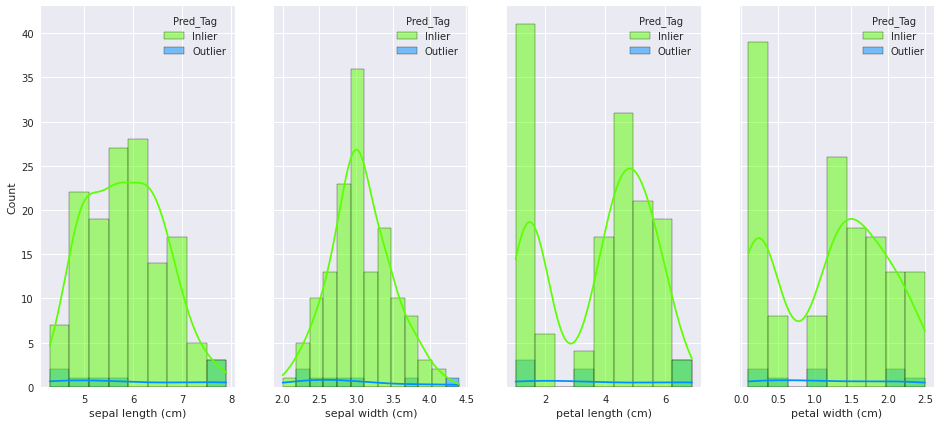

In [48]:
with plt.style.context('seaborn'):
    fig, ax = plt.subplots(1,4,figsize=(16,7),sharex=False,sharey=True)
    sns.histplot(data=if_results,x='sepal length (cm)',hue='Pred_Tag',palette='gist_rainbow',ax=ax[0],kde=True)
    sns.histplot(data=if_results,x='sepal width (cm)',hue='Pred_Tag',palette='gist_rainbow',ax=ax[1],kde=True)
    sns.histplot(data=if_results,x='petal length (cm)',hue='Pred_Tag',palette='gist_rainbow',ax=ax[2],kde=True)
    sns.histplot(data=if_results,x='petal width (cm)',hue='Pred_Tag',palette='gist_rainbow',ax=ax[3],kde=True)

#### **Some gaps are quite evident in the above plots and point to mention here is that majority of the outliers are from the extreme or higher values of features.**

In [49]:
iris_classes = {0:'setosa',1:'versicolor',2:'virginica'}
if_results['Label'] = if_results['Label'].apply(lambda val : iris_classes.get(val))

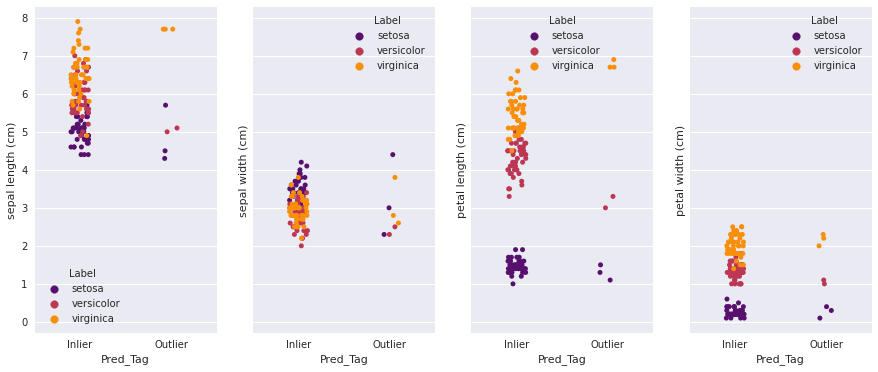

In [50]:
with plt.style.context('seaborn'):
    fig, ax = plt.subplots(1,4,figsize=(15,6),sharex=True,sharey=True)
    sns.stripplot(data=if_results,x='Pred_Tag',y='sepal length (cm)',hue='Label',palette='inferno',ax=ax[0])
    sns.stripplot(data=if_results,x='Pred_Tag',y='sepal width (cm)',hue='Label',palette='inferno',ax=ax[1])
    sns.stripplot(data=if_results,x='Pred_Tag',y='petal length (cm)',hue='Label',palette='inferno',ax=ax[2])
    sns.stripplot(data=if_results,x='Pred_Tag',y='petal width (cm)',hue='Label',palette='inferno',ax=ax[3])

### ***`Similar result was also generated by LOF which means both of these techniques quite have behaved in similar fashion in this dataset.`***

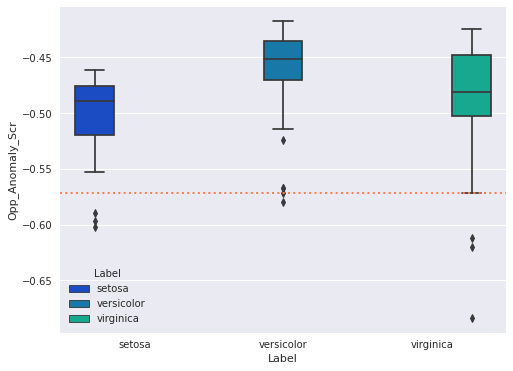

In [54]:
with plt.style.context('seaborn'):
    plt.figure(figsize=(8,6))
    sns.boxplot(data=if_results,x='Label',y='Opp_Anomaly_Scr',hue='Label',palette='winter')
    plt.axhline(iso_for.offset_,color='coral',linestyle=':',linewidth=2)

#### **The Anomalies in Virginica class appears to have a higher anomaly score as compared to others.**

## **Conclusion**
### **In the above analysis, I have encountered a bit of similar results between LOF and IF. I enojyed learning about Isolation Forest, its problems and its extension, however EIF is not available in Sklearn. And, its implementation in EIF library currently doesn't provide much flexibility to the user.**

### **`As Isolation Forest works in a manner that easily isolated observations are outliers by building the binary trees this makes it powerful in identifying the golbal outliers but it kind of fails to identify or capture the local outlier which is near to the normal points but abnormal in nature. LOF doesn't really suffer from this problem. However, the time complexity of IF is better than LOF and the addition of hyperplanes in EIF makes it very suitable for higher dimensional data.`**